EXITO
La cantidad de nodos abiertos fue de: 8
El óptimo recorrido es: [(1, 'ciudad1'), (2, 'ciudad2'), (6, 'ciudad3'), (12, 'ciudad4'), (16, 'ciudad5')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad2', 'ciudad3', 'ciudad4', 'ciudad5']
El costo total del óptimo recorrido es de: 30


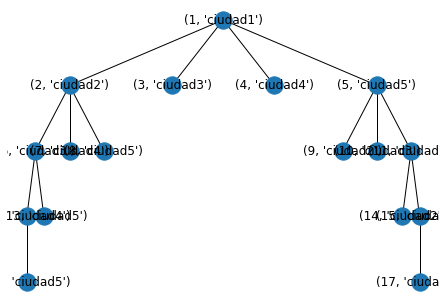

In [16]:
'''
PRUEBA 3

Algoritmo A*
1) Cree un grafo de búsqueda G y una lista ABIERTA y ponga a s en cada uno de ellos.
2) Cree una lista vacía CERRADA.
3) Si ABIERTA está vacía retorne con Falla.
4) Remueva el 1er nodo = n de ABIERTA y colóquela en CERRADA.
5) Si n = Meta retorne con Éxito.
6) Genere los M sucesores de n que no sean sus ancestros y póngalos en G.
7) Establezca punteros a n desde sus descendientes que no estén ni en ABIERTA ni en CERRADA
    agregue los M sucesores a la lista ABIERTA y en caso que ya estuvieran redireccione los punteros
    si es un camino más corto.
8) Reordene ABIERTA.
9) Vaya al punto 3

'''
import networkx as nx
import matplotlib as plt
import numpy as np
import random

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):
    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
'''
# ejemplo de uso de la funcion anterior:
G = nx.Graph()
G.add_edges_from([(1,2), (1,3), (1,4), (2,5), (2,6), (2,7), (3,8), (3,9), (4,10),
                  (5,11), (5,12), (6,13)])
pos = hierarchy_pos(G,1)    
nx.draw(G, pos=pos, with_labels=True)
'''

def debuggear(listAbierta,listCerrada):
    print("listAbierta: {}, listCerrada: {}".format(listAbierta,listCerrada))
    return

# TODAVIA NO LA USO...
# esta funcion devuelve la ciudad de menor costo de transporte desde la ciudad variable <inicio>
def calcMenCost(cantCiu,mat_costCiu,inicio,listExceptuadas):
    listExceptuadas.append(inicio)
    vec_costCiu_aux = mat_costCiu[inicio-1]
    #print("vec cost Ciu: {}".format(vec_costCiu_aux))
    menor = -1
    dest = -1
    a = 0
    while (menor == -1 and dest == -1):
        if (a+1) not in listExceptuadas:
            menor = vec_costCiu_aux[a]
            dest = (a+1)
        else:
            a += 1
    for a in range(cantCiu-1):
        if (a+1) in listExceptuadas:
            continue
        aux = vec_costCiu_aux[a]
        if menor > aux and aux != 0:
            menor = aux
            dest = (a+1)
    return dest,listExceptuadas

def costoDeSaM(grafoG,mat_costCiu,nodo_s,nodo_m):
    # se calcula el costo desde el inicio S hasta M con M todos los nodos no ABIERTOS
    Gn = 0
    aux = nodo_m
    while (aux != nodo_s):
        vecinos = grafoG.neighbors(aux)
        padres = []
        for vecino in vecinos:
            if not vecino == None:
                padres.append((aux,vecino))
        for a in padres:
            if a[0] == aux:
                # el nodo_m(aux) tiene padre
                Gn += costoDeNaM(mat_costCiu,a[0],a[1])
                # hay que conocer, ahora, quien es el abuelo de nodo_m(aux)
                aux = a[1]
                break
    return Gn

def costoDeNaM(mat_costCiu,nodo_n,nodo_m):
    nro_ciudadN = int(nodo_n[1].split('ciudad')[1])
    nro_ciudadM = int(nodo_m[1].split('ciudad')[1])
    return mat_costCiu[nro_ciudadN-1][nro_ciudadM-1]

def calcularHn(grafoG,mat_costCiu,vec_costCiu,nodo_s,nodo_m):
    # se estima el costo desde M hasta el final con M todos los nodos no ABIERTOS
    vec_aux = [a for a in vec_costCiu] # vec_costCiu = [5,15,17,7,6,19,20,7,21,5]
    aux = nodo_m
    nivel = 0 #esta variable se utilizara para conocer el nivel de profundidad (0 es (1,'ciudad1')) en el que se encuentra el nodo_m dentro del grafo
    while (aux != nodo_s):
        vecinos = grafoG.neighbors(aux)
        padres = []
        for vecino in vecinos:
            if not vecino == None:
                padres.append((aux,vecino))
        for a in padres:
            if a[0] == aux:
                # el nodo_m(aux) tiene padre
                # se le quita el costo del recorrido desde nodo_m a su padre
                vec_aux.remove(costoDeNaM(mat_costCiu,a[0],a[1]))
                nivel += 1
                # hay que conocer, ahora, quien es el abuelo de nodo_m(aux)
                aux = a[1]
                break

    # se ordena ascendentemente el vector de costos de todos los recorridos
    vec_aux.sort(reverse=False)
    # se toman los primeros (5-nivel) valores y se los sumariza en Hn
    Hn = 0
    for a in (vec_aux[:len(mat_costCiu[0])-nivel]): #len(mat_costCiu[0]) es la cantidad de ciudades ya que representa la cantidad de columnas de la matriz
        Hn += a
    return Hn

''' OBSOLETO
def calcularHn(mat_costCiu,vec_costCiu,nodo_n,nodo_m,nivel):
    # se copia el vector vec_costCiu en aux
    aux = [a for a in vec_costCiu] # vec_costCiu = [5,15,17,7,6,19,20,7,21,5]
    # se le quita el costo que tendria dicho recorrido
    aux.remove(costoDeNaM(mat_costCiu,nodo_n,m))
    # se ordena ascendentemente dicho vector
    aux.sort(reverse=False)
    # se toman los primeros (5-nivel) valores y se los sumariza en Hn
    Hn = 0
    for a in (aux[:len(mat_costCiu[0])-nivel]): #len(mat_costCiu[0]) es la cantidad de ciudades ya que representa la cantidad de columnas de la matriz
        Hn += a
    return Hn
'''

def agregarCiudadesDesdeN(id_autoinc, grafoG, nodo_n, ciudades_a_agregar):
    edges = []
    sucesores = []
    for a in ciudades_a_agregar:
        sucesores.append((id_autoinc,a))
        edges.append([nodo_n,sucesores[-1:][0]])
        id_autoinc += 1

    grafoG.add_edges_from(edges)
    return id_autoinc, grafoG, sucesores

cantCiu = 5
vec_costCiu = [5,15,17,7,6,19,20,7,21,5]
mat_costCiu = [
    [ 0, 5,15,17, 7],
    [ 5, 0, 6,19,20],
    [15, 6, 0, 7,21],
    [17,19, 7, 0, 5],
    [ 7,20,21, 5, 0]
]
nodos = [(a,"ciudad{}".format(a)) for a in range(1,cantCiu+1)]
id_autoinc = cantCiu + 1 #id_autoinc lo uso como identificador de nodo

## Modelo mi algoritmo A* de forma tal que cada nodo del grafo es una ciudad
## la ciudad de inicio y de fin será la 1 pero terminará habiendo recorrido todas las ciudades

'''
1) Se crea un grafo de busqueda G y una lista ABIERTA y se coloca a s en cada uno de ellos.
'''
# creacion del grafo de busqueda G
grafoG = nx.Graph()
# creacion lista ABIERTA
listAbierta = [a for a in nodos] #se copian todos los elementos de nodos en listAbierta
#ver si conviene mas poner la 1 y tomar siempre desde el 2do elemento del array
# o si conviene no ponerla y al final sumar su recorrido (costo)

#grafoG.add_edge((1,"ciudad1"),(2,"ciudad2"))
# se agrega al grafo toda la listAbierta (para agregar a un solo nodo se puede usar grafoG.add_node(listAbierta))
edges = []
for a in listAbierta:
    if (a != listAbierta[0]):
        edges.append([listAbierta[0],(a[0],a[1])])

grafoG.add_edges_from(edges)
isTree = nx.is_tree(grafoG) #variable debugging
#peso12 = grafoG[1][2]
# todo: se podrian poner los pesos de cada edge dentro del atributo del edge. Actualmente voy a manejar los costos por afuera y usar al grafo para busquedas
# se actualizan los costos de recorridos
#grafoG.add_weighted_edges_from([(1, 2, 5.0), (1, 3, 10)])

'''
2) Se crea una lista vacía CERRADA.
'''
listCerrada = []

EXIT = False
adyacentes = []

while(len(listAbierta) != 0 and EXIT == False):
    '''
    3) Si ABIERTA está vacía retorne con Falla.
    '''
    if len(listAbierta) == 0:
        print("lista ABIERTA vacia")
        break

    '''
    4) Se remueve el 1er nodo = n de ABIERTA y se lo coloca en CERRADA.
    '''
    # Se remueve el 2do nodo = n (n = 1, es decir, ciudad 2 porque se arrancará de la ciudad 1 e irá a la ciudad 2)
    # y se lo coloca en CERRADA 
    # nota: en nuestro caso n es n_abierto, n_abierto siempre será 0 porque es el primer elemento (0) de la lista
    n_abierto=0
    nodo_n=listAbierta[n_abierto]
    listCerrada.append(listAbierta.pop(n_abierto))

    '''
    5) Si n = Meta se retorna con Éxito.
    '''
    # la condicion de exito es que la cantidad de ciudades distintas recorridas sean cantCiu (en nuestro caso 5)
    # o, lo que es lo mismo, que de todas ciudades haya por lo menos una que no esté en las ciudades dentro de listCerrada

    #listCerrada = nodos #test para saber si esta bien programado el flag
    
    ciudades = [n[1] for n in nodos]
    nodos_a_evaluar = [a for a in listCerrada[1:]]
    cond_exito = False
    nodo_s = listCerrada[0]

    '''adyacentes = []
    for n, nbrsdict in grafoG.adjacency():
        for nbr, eattr in nbrsdict.items():
            adyacentes.append((n,nbr))

    print("ppio: adyacentes: {}".format(adyacentes))
    #TODO: estaría bueno poder limpiar adyacentes y quedarme con las combinaciones únicas que 1,2 y 2,1 resulten en 1,2
    '''

    while (len(nodos_a_evaluar) > 0):
        #ciudades_distintas = 1
        nodo_evaluacion = nodos_a_evaluar[0]
        nodos_a_evaluar = nodos_a_evaluar[1:]

        # Se obtienen las conexiones de los nodos adyacentes entre sí y los parientes del nodo_n

        #adyacentes = adyacentes[:int(len(adyacentes)/2)]

        #print("ppio: ciudades_distintas: {}".format(ciudades_distintas))
        #print("ppio: nodo_evaluacion: {}".format(nodo_evaluacion))
        #print("ppio: nodos_a_evaluar: {}".format(nodos_a_evaluar))

        costo_optimo = 0
        recorrido_optimo = []
        nivel = 1 #esta variable se utilizara para conocer el nivel de profundidad (0 es (1,'ciudad1')) en el que se encuentra el nodo_m dentro del grafo
        while (nodo_evaluacion != nodo_s):
            vecinos = grafoG.neighbors(nodo_evaluacion)
            padres = []
            for vecino in vecinos:
                if not vecino == None:
                    padres.append((nodo_evaluacion,vecino))
            for a in padres:
                if a[0] == nodo_evaluacion:
                    # el nodo_m(aux) tiene padre
                    # se le quita el costo del recorrido desde nodo_m a su padre
                    costo_optimo += costoDeNaM(mat_costCiu,a[0],a[1])
                    recorrido_optimo.append(nodo_evaluacion)
                    nivel += 1
                    # hay que conocer, ahora, quien es el abuelo de nodo_m(aux)
                    nodo_evaluacion = a[1]
                    break

        # se recorre el vector de adyacentes de manera que el destino sea el nodo a evaluar.
        # adyacentes, para el caso de la 2da iteración (nodo 1 y luego nodo 2) resulta:
        # [((1, 'ciudad1'), (2, 'ciudad2')), ((1, 'ciudad1'), (3, 'ciudad3')), ((1, 'ciudad1'), (4, 'ciudad4')),
        #  ((1, 'ciudad1'), (5, 'ciudad5')), ((2, 'ciudad2'), (1, 'ciudad1')), ((2, 'ciudad2'), (6, 'ciudad3')), ((2, 'ciudad2'), (7, 'ciudad4'))]

        # A REHACER PORQUE EL PROGRAMA SE CUELGA EN ESTE PUNTO...
        #while (nodo_evaluacion != nodo_s):
        #    for a in adyacentes:
        #        if a[1] == nodo_evaluacion:
        #            ciudades_distintas += 1
        #            nodo_evaluacion = a[0]
        #            break

        #print("fin: ciudades_distintas: {}".format(ciudades_distintas))
        #print("fin: aux: {}".format(aux))
        #print("fin: nodos_a_evaluar: {}".format(nodos_a_evaluar))

        if (nivel >= len(ciudades)):
            cond_exito = True
            costo_optimo += costoDeNaM(mat_costCiu,recorrido_optimo[0],nodo_s) # se calcula es costo desde la ultima ciudad hasta la primera
            recorrido_optimo.append(nodo_s) #se appendea el nodo de inicio
            recorrido_optimo.reverse()
            recorrido_optimo_ciudades = [a[1] for a in recorrido_optimo]
            break

    #cond_exito = [lambda: False, lambda: True][a in listCerrada]() 
    #cond_exito = [True for a in (nodos) if a in listCerrada]

    if (cond_exito):
        print("EXITO")
        break

    if nodo_n==(16,'ciudad5'):
        #EXIT = True
        pass

    '''
    6) Se generan los M sucesores de n que no sean sus ancestros y se los pone en G.
    '''
    # se recorre el grafo para calcular los M sucesores de n que no sean sus ancestros
    # nota: para el caso particular de la primera iteracion, no hace falta generar sucesores porque ya existen en el grafo y ya estan vinculados
    if nodo_n[0] != 1:
        ''' Se deja como posible funcion a utilizar en algun momento
        # Se obtienen las conexiones de los nodos adyacentes entre sí y los parientes del nodo_n
        for n, nbrsdict in grafoG.adjacency():
            for nbr, eattr in nbrsdict.items():
                adyacentes.append((n,nbr))
        '''
        # 1. se obtienen los M sucesores a agregar, restando a la totalidad de ciudades antecesores de nodo_n y el mismo nodo_n
        nodo_s = listCerrada[0]
        ciudades_a_agregar = [a for a in ciudades if a != nodo_n[1]]
        aux = nodo_n
        while (aux != nodo_s):
            vecinos = grafoG.neighbors(aux)
            padres = []
            for vecino in vecinos:
                if not vecino == None:
                    padres.append((aux,vecino))
            for a in padres:
                if a[0] == aux:
                    # el nodo_m(aux) tiene padre
                    # se le quita el costo del recorrido desde nodo_m a su padre
                    ciudades_a_agregar.remove(a[1][1])
                    # hay que conocer, ahora, quien es el abuelo de nodo_m(aux)
                    aux = a[1]
                    break

        # 2. se agregan los M sucesores del nodo nodo_n al grafo G.
        id_autoinc, grafoG, sucesores = agregarCiudadesDesdeN(id_autoinc, grafoG, nodo_n, ciudades_a_agregar)

    '''
    7) Establezca punteros a n desde sus descendientes que no estén ni en ABIERTA ni en CERRADA
        agregue los M sucesores a la lista ABIERTA y en caso que ya estuvieran redireccione los punteros
        si es un camino más corto.
    '''
    if nodo_n[0] != 1:
        # 1. TODO: habría que evaluar recalcular costos reacomodar la listaAbierta
        #          (no estoy seguro de este reordenamiento y tampoco sé como implementarlo)
        
        # 2. se agregan los M sucesores a la lista ABIERTA
        for a in sucesores:
            listAbierta.append(a)
        
    '''
    8) Reordene ABIERTA
    '''
    # para recorrer el grafo primero se deberan hallar los costos actuales y estimados en cada nodo
    # en principio el costo actual del nodo abierto (1,'ciudad1') es 0
    # h(n) está representado por Hn: costo minimo posible de todo el recorrido (condicion algoritmo A*)
    # pero el estimado deberá ser la suma de los menores costos calculado desde el nodo recien abierto

    # se calcula h(n) en base a los menores costos de los recorridos posibles desde el nodo recien abierto
    Fn = []
    Gn = []
    Hn = []
    nodo_s = listCerrada[0]
    for nodo_m in listAbierta:
        #TODO: realizar la cuenta pero tomando los padres del nodo m y realizando el dropdown hasta el nodo m
        Gn.append(costoDeSaM(grafoG,mat_costCiu,nodo_s,nodo_m)) #está hardcodeado el nodo inicio (S)
        Hn.append(calcularHn(grafoG,mat_costCiu,vec_costCiu,nodo_s,nodo_m))
        Fn.append(Gn[-1:][0] + Hn[-1:][0]) #f(n) = g(n) + h(n)

    # Se procede a ordenar Lista Abierta en base a la función para Algoritmo A*: f(n) = g(n) + h(n)
    # en detalle: se ordena listAbierta, Gn, Hn y Fn en función del ordenamiento de Fn
    Fn,Gn,Hn,listAbierta = zip(*sorted(zip(Fn,Gn,Hn,listAbierta), reverse=False))
        #zip genera un array (lista) de tuplas con, [(Fn[0],Gn[0],Hn[0],listAbierta[0]),(Fn[1],Gn[1],Hn[1],listAbierta[1]),(...)]
        #sorted(zip) ordena dicho array en orden ascendente
        #zip(*) hace un unpack del primer zip, es decir, deshace el primer zip y desglosa la salida en tuplas.
    # arreglo las tuplas anteriores para que resulten arrays (listas)
    Fn,Gn,Hn,listAbierta = list(Fn),list(Gn),list(Hn),list(listAbierta)

# se imprimen la cantidad de nodos abiertos:
print("La cantidad de nodos abiertos fue de: {}".format(len(listCerrada)))
# se imprime el recorrido óptimo y su costo
print("El óptimo recorrido es: {}".format(recorrido_optimo))
print("O dicho de otro modo el recorrido es: {}".format(recorrido_optimo_ciudades))
print("El costo total del óptimo recorrido es de: {}".format(costo_optimo))

# se dibuja el grafo
pos = hierarchy_pos(grafoG,(1,"ciudad1"))    
nx.draw(grafoG, pos=pos, with_labels=True)

#nx.draw(grafoG, pos=nx.spring_layout(grafoG))
#pos = nx.spring_layout(grafoG)  # positions for all nodes
#nx.draw_networkx_nodes(grafoG, pos, node_size=700)
#nx.draw_networkx_labels(grafoG, pos, font_size=16, font_family="sans-serif")